NOTES:


*   The scraping results is saved into a csv file named 'beer.csv'

*   The result of word frequency counts for all reviews is stored in a csv file called 'word frequency.csv'

*  The input 3 attributes are stored in a file named 'inputfile.txt', with each attribute on a signle line. 3 attributes used in this project are: spicy, complex, aroma

*   The output file of the cos-similarity function is called 'outputfile.csv'

*   All these files are attached along with the submition of this python notebook


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')


from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 26.4 MB/s 


## Scrape Data

In [ ]:
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By

#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 995 kB 5.1 MB/s 
     |████████████████████████████████| 384 kB 52.4 MB/s 
     |████████████████████████████████| 140 kB 53.8 MB/s 
     |████████████████████████████████| 58 kB 2.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
wd = webdriver.Chrome('chromedriver',options=chrome_options)

In [ ]:
beers = []
ratings=[]
reviews=[]
links_dict = {}
for i in range(250):
  wd.get('https://www.beeradvocate.com/beer/top-rated/')
  name = wd.find_element(by=By.XPATH, value ='//*[@id="ba-content"]/table/tbody/tr[' +str(i+2)+ ']/td[2]/a/b').text
  link = wd.find_element(by=By.XPATH, value='//*[@id="ba-content"]/table/tbody/tr[' +str(i+2)+ ']/td[2]/a').get_attribute('href')
  links_dict.update({name:link})
for beer_name in links_dict:
  wd.get(links_dict[beer_name])
  rating = wd.find_elements(by=By.CLASS_NAME, value='BAscore_norm')
  review = wd.find_elements(by=By.XPATH, value='//*[@id="rating_fullview_content_2"]/div')
  for rt in rating:
    ratings.append(rt.text)
    beers.append(beer_name)
  for rw in review:
    reviews.append(rw.text)

beer_df = pd.DataFrame({ "Beer": beers, "Rating" : ratings, "Review": reviews})
beer_df.to_csv('beers.csv')

## Word Frequency

In [ ]:
beer = pd.read_csv('beers.csv')
beer.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
stop_words = stopwords.words('english') + list(string.punctuation)
beer['review tokens'] = beer['Review'].apply(word_tokenize)

def filtered(tokens):
    no_stopwords = [word.lower() for word in tokens if word.lower() not in stop_words]
    return list(no_stopwords)

beer['filtered review'] = beer['review tokens'].apply(filtered)

In [ ]:
word_freq_dict = dict()

def freqCount(review):
    for word in review:
        if word in word_freq_dict:
            word_freq_dict[word] +=1
        else:
            word_freq_dict[word] = 1
    return word_freq_dict

full_review = [word for r in beer['filtered review'].values for word in r]
word_freq_dict = freqCount(full_review)
word_freq = pd.DataFrame(list(word_freq_dict.items()),columns = ['word','freq']).sort_values(by='freq',ascending=False).reset_index(drop=True)
word_freq.to_csv('word frequency.csv')

In [ ]:
#Top ten most mentioned words
#word_freq.head(10)

In [ ]:
beer.head(5)

,Beer,Rating,Review,review tokens,filtered review
0,Kentucky Brunch Brand Stout,5.00,I didnt think i was going to give it a perfect...,"[I, didnt, think, i, was, going, to, give, it,...","[didnt, think, going, give, perfect, score, ....."
1,Kentucky Brunch Brand Stout,3.79,So I just read a review that called the legend...,"[So, I, just, read, a, review, that, called, t...","[read, review, called, legendary, kbbs, “, typ..."
2,Kentucky Brunch Brand Stout,4.64,"2021 vintage, bottle #79\n\nHoly. Fucking. Shi...","[2021, vintage, ,, bottle, #, 79, Holy, ., Fuc...","[2021, vintage, bottle, 79, holy, fucking, shi..."
3,Kentucky Brunch Brand Stout,4.27,"Celebrating my buddy @Rug with his 1,000th bee...","[Celebrating, my, buddy, @, Rug, with, his, 1,...","[celebrating, buddy, rug, 1,000th, beer, revie..."
4,Kentucky Brunch Brand Stout,4.79,"Thick and syrupy pour, mocha head. Aroma is bo...","[Thick, and, syrupy, pour, ,, mocha, head, ., ...","[thick, syrupy, pour, mocha, head, aroma, booz..."


## Cosine Similarity Score

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def list_to_str(review_list):
    return ' '.join(review_list)

#The input is obtained in a format of 3 single pop-up windows
def cos_sim(review):
    input_att = []
    for i in range(3):
        input_att.append(input('Type three attribute in total to descibe your desired beer: '))
    input_att = " ".join(input_att)
    tfidf_vec = TfidfVectorizer()
    tfidf = tfidf_vec.fit_transform([input_att, review])
    return ((tfidf * tfidf.T).A)[0,1]

#The inputfile is with the assumption of each attribute is on a single line
def cos_simi(review,input_att):
    #input_att = open("inputfile.txt", "r").read().split('\n')
    #input_att = " ".join(input_att)

    #tfidf_vec = TfidfVectorizer()
    #tfidf = tfidf_vec.fit_transform([review, input_att])

    count_vectorizer = CountVectorizer(stop_words='english')
    sparse_matrix = count_vectorizer.fit_transform([review, input_att])
    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(doc_term_matrix,
                      columns=count_vectorizer.get_feature_names_out(),
                      index=['x', 'y'])
    return cosine_similarity(df, df)[0,1]

In [ ]:
#This function takes the input file and output a csv file containing the three required columns: 
#                                                                         beer name, review, and cosine similarity score
def get_similarity_output_file(file):
  inputs = open(file, "r").read().split('\n')
  inputs = " ".join(inputs)
  result = beer.copy()
  result['similarity score'] = result['filtered review'].map(list_to_str).apply(cos_simi,input_att=inputs)
  result.drop(columns=['Rating','review tokens','filtered review'],inplace=True)
  return result.to_csv('outputfile.csv', index=False)

In [ ]:
#Preview of result saved in the otputfile.csv file
get_similarity_output_file('inputfile.txt')
output = pd.read_csv('outputfile.csv')
output.head(5)

,Beer,Review,similarity score
0,Kentucky Brunch Brand Stout,I didnt think i was going to give it a perfect...,0.000000
1,Kentucky Brunch Brand Stout,So I just read a review that called the legend...,0.030817
2,Kentucky Brunch Brand Stout,"2021 vintage, bottle #79\n\nHoly. Fucking. Shi...",0.067003
3,Kentucky Brunch Brand Stout,"Celebrating my buddy @Rug with his 1,000th bee...",0.000000
4,Kentucky Brunch Brand Stout,"Thick and syrupy pour, mocha head. Aroma is bo...",0.111111


## Sentiment Analysis

In [ ]:
beer_new = beer[['Beer','Rating','filtered review']]
beer_new['filtered review'] = beer_new['filtered review'].map(list_to_str)
inputs = open('inputfile.txt', "r").read().split('\n')
inputs = " ".join(inputs)
beer_new['similarity score'] = beer_new['filtered review'].apply(cos_simi,input_att=inputs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
newWords={'hell':0}
analyser.lexicon.update(newWords)

def get_sentiment(review, **kwargs):
  sentiment_score = analyser.polarity_scores(review)
  positive_score = (sentiment_score['pos'])
  negative_score = (sentiment_score['neg'])
  compound_score = (sentiment_score['compound'])
  if kwargs['k'] == 'positive':
    return positive_score
  elif kwargs['k'] == 'negative':
    return negative_score
  elif kwargs['k'] == 'compound':
    return compound_score


beer_new['positive'] = beer_new['filtered review'].apply(get_sentiment, k='positive')
beer_new['negative'] = beer_new['filtered review'].apply(get_sentiment, k='negative')
beer_new['compound'] = beer_new['filtered review'].apply(get_sentiment, k='compound')

In [ ]:
beer_new

,Beer,Rating,filtered review,similarity score,positive,negative,compound
0,Kentucky Brunch Brand Stout,5.00,didnt think going give perfect score ..... loo...,0.000000,0.243,0.000,0.9460
1,Kentucky Brunch Brand Stout,3.79,read review called legendary kbbs “ typical…wh...,0.030817,0.269,0.043,0.9966
2,Kentucky Brunch Brand Stout,4.64,2021 vintage bottle 79 holy fucking shit kbbs ...,0.067003,0.215,0.085,0.9843
3,Kentucky Brunch Brand Stout,4.27,"celebrating buddy rug 1,000th beer review pour...",0.000000,0.350,0.036,0.9702
4,Kentucky Brunch Brand Stout,4.79,thick syrupy pour mocha head aroma boozy maple...,0.111111,0.268,0.039,0.8225
...,...,...,...,...,...,...,...
2241,Expedition Stout - Bourbon Barrel-Aged,4.49,pours thick oily black vigorous pours n't get ...,0.102062,0.283,0.000,0.9081
2242,Expedition Stout - Bourbon Barrel-Aged,4.18,2021-11-27 12oz bottle served pair georgetown ...,0.000000,0.163,0.045,0.8020
2243,Expedition Stout - Bourbon Barrel-Aged,4.57,2018 vintage 12oz bottle poured tulip a- pours...,0.037823,0.165,0.000,0.9638
2244,Expedition Stout - Bourbon Barrel-Aged,4.43,annual beer grab generally availed midwest pou...,0.136083,0.171,0.000,0.5106


## Task E:
## Recommendation using bag of words （cosine similarity + sentiment analysis）

In [ ]:
beer_score = beer_new.groupby('Beer')[['similarity score','compound']].mean().reset_index()
beer_score.rename(columns={'compound':'sentiment score'}, inplace=True)
beer_score['total score'] = beer_score['similarity score'] * beer_score['sentiment score']
beer_score

,Beer,similarity score,sentiment score,total score
0,4th Anniversary,0.039242,0.728600,0.028592
1,A Deal With The Devil - Double Oak-Aged,0.058046,0.750467,0.043562
2,A Deal With The Devil - Triple Oak-Aged,0.000000,0.618117,0.000000
3,Abner,0.025261,0.823885,0.020812
4,Abrasive Ale,0.035000,0.835945,0.029258
...,...,...,...,...
243,XTRA DUBL Benthic,0.022598,0.912814,0.020628
244,Yellow Bus,0.014358,0.829271,0.011906
245,Zenne Y Frontera,0.036643,0.913517,0.033474
246,Zombie Dust,0.019361,0.520171,0.010071


In [ ]:
beer_score.sort_values(by='total score', ascending = False).head(3)

,Beer,similarity score,sentiment score,total score
222,The Rusty Nail,0.078089,0.914211,0.071390
21,Aurelian Lure,0.059549,0.961700,0.057268
40,Bourbon Barrel Oro Negro,0.077087,0.722200,0.055672


###Part (iii)
Looking at the top 3 total score table above, I would recommend the following 3 products to the customer: The Rusty Nail (0.071390), Aurelian Lure (0.057268), and Bourbon Barrel Oro Negro (0.055672).


Similarity & Sentiment Scores for Top 3 Recommmendations:
* The Rusty Nail (0.078089 & 0.914211)
* Aurelian Lure (0.059549 & 0.961700)
* Bourbon Barrel Oro Negro (0.077087	& 0.722200)

## Task F:
## Recommendation using word vectors (spaCy package) 

In [ ]:
#spaCy uses word vectors for medium (md) and large (lg)
#!pip install -U pip setuptools wheel
#!pip install spacy
import spacy 
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md') 

def spacy_similarity(review):
  inputs = open('inputfile.txt', "r").read().split('\n')
  inputs = " ".join(inputs)
  r = nlp(review)
  i = nlp(inputs)
  return r.similarity(i)


beer_spacy = beer_new.copy()
beer_spacy['spacy score'] = beer_spacy['filtered review'].map(spacy_similarity)
beer_spacy

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  del sys.path[0]


,Beer,Rating,filtered review,similarity score,positive,negative,compound,spacy score
0,Kentucky Brunch Brand Stout,5.00,didnt think going give perfect score ..... loo...,0.000000,0.243,0.000,0.9460,0.579991
1,Kentucky Brunch Brand Stout,3.79,read review called legendary kbbs “ typical…wh...,0.030817,0.269,0.043,0.9966,0.593420
2,Kentucky Brunch Brand Stout,4.64,2021 vintage bottle 79 holy fucking shit kbbs ...,0.067003,0.215,0.085,0.9843,0.651333
3,Kentucky Brunch Brand Stout,4.27,"celebrating buddy rug 1,000th beer review pour...",0.000000,0.350,0.036,0.9702,0.656953
4,Kentucky Brunch Brand Stout,4.79,thick syrupy pour mocha head aroma boozy maple...,0.111111,0.268,0.039,0.8225,0.756148
...,...,...,...,...,...,...,...,...
2232,Expedition Stout - Bourbon Barrel-Aged,4.49,pours thick oily black vigorous pours n't get ...,0.102062,0.283,0.000,0.9081,0.590578
2233,Expedition Stout - Bourbon Barrel-Aged,4.18,2021-11-27 12oz bottle served pair georgetown ...,0.000000,0.163,0.045,0.8020,0.630484
2234,Expedition Stout - Bourbon Barrel-Aged,4.57,2018 vintage 12oz bottle poured tulip a- pours...,0.037823,0.165,0.000,0.9638,0.725009
2235,Expedition Stout - Bourbon Barrel-Aged,4.43,annual beer grab generally availed midwest pou...,0.136083,0.171,0.000,0.5106,0.420486


In [ ]:
beer_simi_spacy = beer_spacy.groupby('Beer')[['spacy score']].mean().reset_index()
beer_simi_spacy = beer_simi_spacy.merge(beer_score, on='Beer')
#beer_simi_spacy.drop(columns=['similarity score','sentiment score'],inplace=True)
beer_simi_spacy['total spacy'] = beer_simi_spacy['spacy score'] * beer_simi_spacy['sentiment score']
beer_simi_spacy.rename(columns={'total score':'total bow'}, inplace=True)
beer_simi_spacy

,Beer,spacy score,similarity score,sentiment score,total bow,total spacy
0,4th Anniversary,0.548787,0.039242,0.728600,0.028592,0.399846
1,A Deal With The Devil - Double Oak-Aged,0.600858,0.058046,0.750467,0.043562,0.450924
2,A Deal With The Devil - Triple Oak-Aged,0.458471,0.000000,0.618117,0.000000,0.283389
3,Abner,0.612006,0.025261,0.823885,0.020812,0.504223
4,Abrasive Ale,0.675035,0.035000,0.835945,0.029258,0.564292
...,...,...,...,...,...,...
243,XTRA DUBL Benthic,0.651293,0.022598,0.912814,0.020628,0.594510
244,Yellow Bus,0.666764,0.014358,0.829271,0.011906,0.552929
245,Zenne Y Frontera,0.707174,0.036643,0.913517,0.033474,0.646015
246,Zombie Dust,0.550516,0.019361,0.520171,0.010071,0.286362


In [ ]:
beer_simi_spacy.sort_values(by='total spacy', ascending = False).head(3)

,Beer,spacy score,similarity score,sentiment score,total bow,total spacy
191,Red Eye November,0.725647,0.020016,0.954750,0.019110,0.692811
96,Flora Plum,0.692380,0.047654,0.937060,0.044655,0.648802
245,Zenne Y Frontera,0.707174,0.036643,0.913517,0.033474,0.646015


## Compare results from BoW and Word Embedding

In [ ]:
beer_compare = beer.copy()
beer_bow = beer_score.sort_values(by='total score', ascending = False).head(3)['Beer'].values
input_attr = open('inputfile.txt', "r").read().split('\n')

mention_matrix_bow = pd.DataFrame(index=beer_bow, columns=input_attr)

for brand in beer_bow:
  beer_compare[brand] = beer_compare['Beer'].map(lambda x: 1 if brand==x else 0)

for feature in input_attr:
  beer_compare[feature] = beer_compare['filtered review'].map(lambda x: 1 if feature in x else 0)

for brand in beer_bow:
  review = sum(beer_compare[brand]==1)
  for feature in input_attr:
      mention = sum((beer_compare[brand]==1) & (beer_compare[feature]==1))
      percentage = mention/review * 100
      mention_matrix_bow.loc[brand, feature] = percentage
mention_matrix_bow


,complex,spicy,aroma
The Rusty Nail,38.888889,5.555556,61.111111
Aurelian Lure,0.0,0.0,100.0
Bourbon Barrel Oro Negro,9.090909,45.454545,36.363636


In [ ]:
beer_spacy = beer_simi_spacy.sort_values(by='total spacy', ascending = False).head(3)['Beer'].values
input_attr = open('inputfile.txt', "r").read().split('\n')

mention_matrix_spacy = pd.DataFrame(index=beer_spacy, columns=input_attr)

for brand in beer_spacy:
  beer_compare[brand] = beer_compare['Beer'].map(lambda x: 1 if brand==x else 0)

for brand in beer_spacy:
  review = sum(beer_compare[brand]==1)
  for feature in input_attr:
      mention = sum((beer_compare[brand]==1) & (beer_compare[feature]==1))
      percentage = mention/review * 100
      mention_matrix_spacy.loc[brand, feature] = percentage
mention_matrix_spacy


,complex,spicy,aroma
Red Eye November,0.0,25.0,0.0
Flora Plum,20.0,20.0,40.0
Zenne Y Frontera,16.666667,0.0,50.0


## Task F Insights: 

The top 3 recommendations using word vectors (the spaCy package) are Red Eye November, Flora Plum, and Zenne Y Frontera.

The top 3 recommendations using bag-of-words are The Rusty Nail, Aurelian Lure, and Bourbon Barrel Oro Negro.


---


There are many differences across the bag-of-words and word vector approach. First,both approaches recommend different "top 3 beers". Moreover, the values for complex, spicy, and aroma are drastically different. 

In the bag-of-words approach, the top 3 beers have higher percentages (max of 61.11) than the word vector approach (max of 50). The Rusty Nail had high complex and aroma percentages of 38.89 and 61.11 respectively. Similarly, the Bourbon Barrel Oro Negro has spicy and aroma percentages of 45.45 and 36.36 respectively. While Aurelian Lure had a value of 0 for complex and spicy, the beer has a high aroma of 100.  

On the other hand, the word vector approach has lower percentages for each attribute in the recommended beer. An example of this is Red Eye November, which has a percentage of 25 for spicy and percentages of 0 for the complex and aroma attributes. Amongst the top 3 recommendations utilizing the word vector approach, Flora Plum had the highest percentage of 80% collectively between the attributes: complex (20%), spicy (20%), and aroma (40%). Even though Zenne Y Frontera has a high percentage of 50 for the aroma attribute, the beer only has a 16.67% for the complex attribute and 0% for the spicy attribute.

In general, the difference between the word embedding and the bag of words is that: bag of words is focusing more on finding the exact words(attributes) whereas word embedding assumes words(attributes) that often appears together are similar. In our situation, 'spicy' and 'aroma' are mentioned together a lot of times, hence spaCy may treat those two features the same, counting one of the feature more and ignoring the other. That mighht expalin the different results we have by using the two different recommendation systems.

## Task G:
## Recommendation using ONLY user ratings (ignore similarity and sentiment score)

In [ ]:
beer.groupby('Beer')[['Rating']].mean().sort_values(by='Rating',ascending = False).head(3)


,Rating
Beer,
The Adjunct Trail - Bourbon Barrel-Aged,4.930000
Twice the Daily Serving: Raspberry,4.833333
Art,4.810000


## Task G Insights: 

If I ignore the similarity and sentiment score and simply chose the 3 highest rated products from my entire dataset, my recommendation would be The Adjunct Trail - Bourbon Barrel-Aged, Twice the Daily Serving: Raspberry, Art. 

If we take into account the similarity and sentiment score, the top 3 highest ratest products would be The Rusty Nail, Aurelian Lure, and Bourbon Barrel Oro Negro instead.


---


The top 3 beers without factoring in the similarity and sentiment score would not meet the requirements of the user looking for recommendations. This is because the beers recommended would not be associated with the three attributes (complex, spicy, and aroma) that the user wants. The purpose of the recommendation system is to offer useful suggestions to users based on their preference. Ignoring the preferences and simply offering the top 3 beers will most likely give a user some beers other people found good based on some totally different preferences. 

For example, the highest rating beer 'The Adjunct Trail - Bourbon Barrel-Aged' has only 1 review and it was about 'coconut','roasty bitterness', and 'hazelnut', which has nothing related to our attributes "spicy, complex, aroma".

While by using the similarity score and the sentiment score, we can know if a review is related to our three attributes, how much they are related to each other, and whether they are related to each other in the positve or negative way. In this way, the recommendation system is way more accuarate by taking users' preferences as input and generate results based on specific preferences. 

## Task H:

## Recommendation using lift between beers and attributes

In [ ]:
#Based on the word frequency.csv output file, the top attributes of beer are: sweet, aroma, thick, malt, smooth, mouthfeel, creamy, smell, bitter, balanced, 
top4attr = ['sweet','aroma','thick','malt']

#10 beers chosen from the top250 beer list. 
#Picked beers with relatively more and less ratings on purpose, trying to see if a more popular beer can generate a less popular but similar one
beer_list = ['Heady Topper','Bourbon County Brand Coffee Stout','Pliny The Elder','KBS','Zombie Dust',
             'Kentucky Brunch Brand Stout','Marshmallow Handjee','King Julius','Fundamental Observation','Juice Machine',]

beer_lift = beer.copy()

for feature in top4attr:
  beer_lift[feature] = beer_lift['filtered review'].map(lambda x: 1 if feature in x else 0)

for brand in beer_list:
  beer_lift[brand] = beer_lift['Beer'].map(lambda x: 1 if brand==x else 0)

#Lift matrix for top_4_features and 10_brands
feature_matrix = pd.DataFrame(index=beer_list, columns=top4attr)

for brand in beer_list:
  num_brand = sum(beer_lift[brand]==1)
  for feature in top4attr:
      num_feature = sum(beer_lift[feature]==1)
      co_mention = sum((beer_lift[brand]==1) & (beer_lift[feature]==1))
      lift = len(beer_lift)*co_mention/(num_brand*num_feature)
      feature_matrix.loc[brand, feature] = lift
feature_matrix


,sweet,aroma,thick,malt
Heady Topper,0.690369,1.293282,0.59734,1.086774
Bourbon County Brand Coffee Stout,1.416141,0.331611,0.918985,1.11464
Pliny The Elder,1.380738,1.293282,0.398227,1.932043
KBS,0.876659,0.205283,0.568896,0.345008
Zombie Dust,0.657494,0.615849,0.284448,2.415054
Kentucky Brunch Brand Stout,0.0,0.808301,1.866689,0.452823
Marshmallow Handjee,1.380738,0.862188,1.792021,1.449032
King Julius,0.862961,1.347169,1.493351,0.905645
Fundamental Observation,2.30123,1.197483,2.322991,0.402509
Juice Machine,1.314988,1.231697,1.706687,0.517512


### MDS maps based on lift between beers and feature

##### Each MDS map shows the similarity among all 10 beers regarding to one single feature

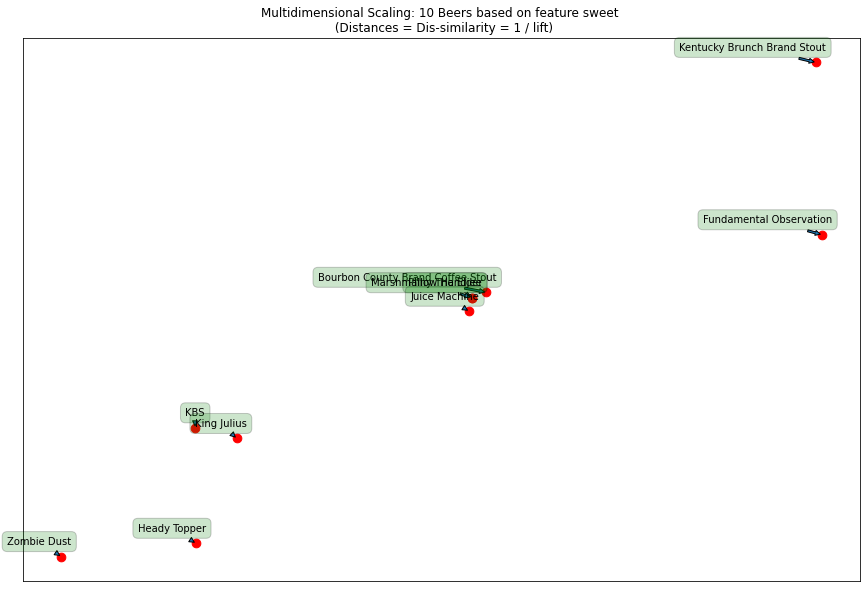

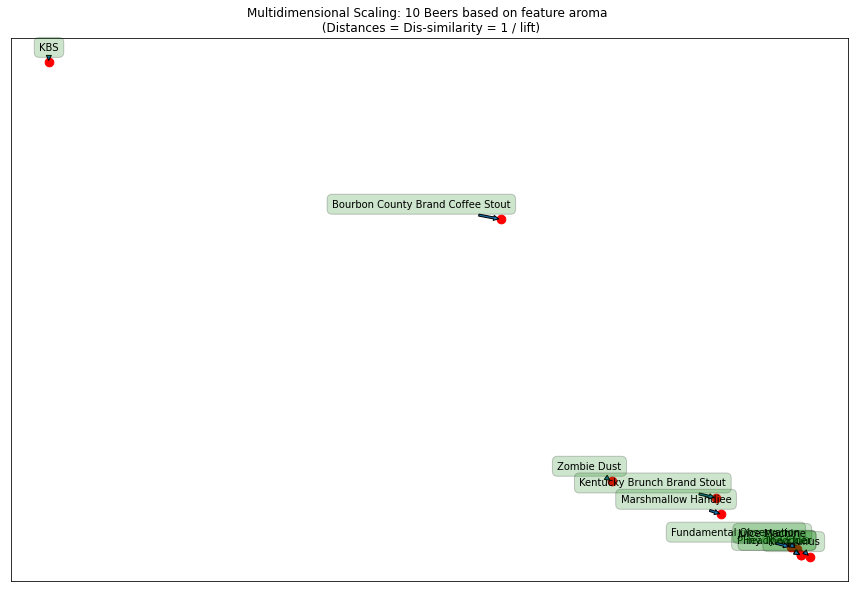

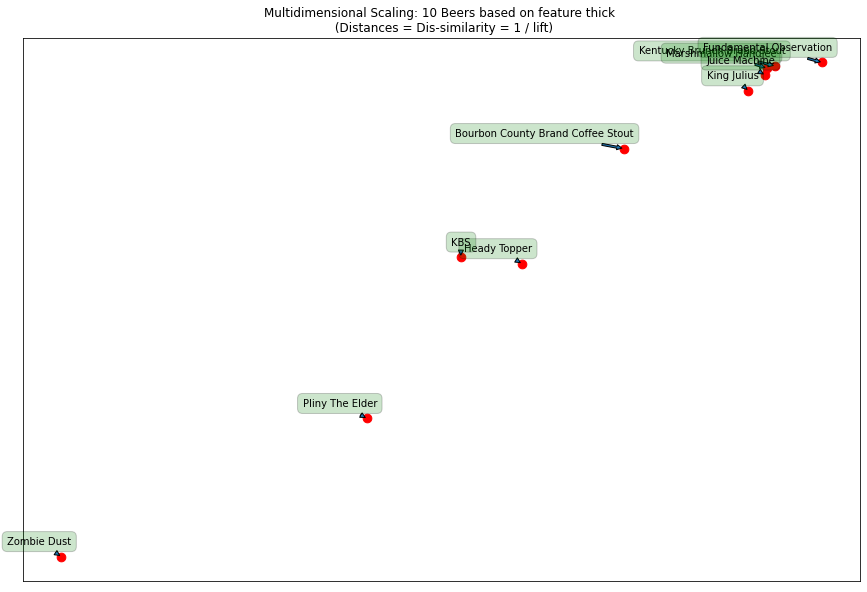

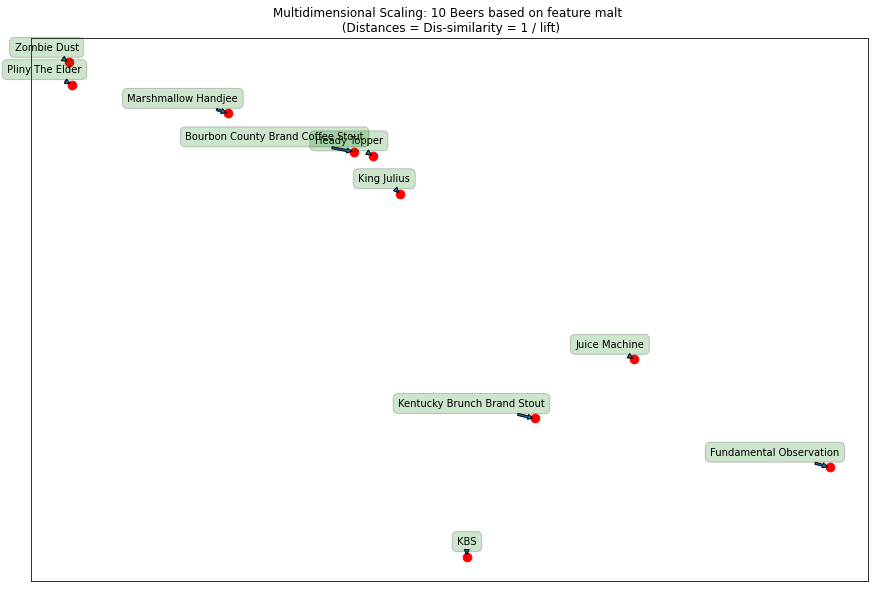

In [ ]:
from sklearn import manifold
from sklearn.manifold import MDS

for attr in top4attr:

  df = feature_matrix[attr].map(lambda x: 1/x if x != 0 else 0).to_frame()
  
  mds=manifold.MDS(n_components=2, dissimilarity ='euclidean', random_state=10)
  results=mds.fit(df)
  coordinates=results.embedding_

  x = coordinates[:,0]
  y = coordinates[:,1]

  plt.figure(figsize=(15,10))
  plt.scatter(x,y, marker='o', color='red', s=75)

  for brand, x_coord, y_coord in zip(list(beer_list), x, y):
    plt.annotate(s=brand, 
                xy=(x_coord,y_coord),
                xytext = (10, 10),
                textcoords = 'offset points', 
                ha = 'right', 
                va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.2),
                arrowprops = dict(arrowstyle = 'simple', connectionstyle = 'arc3,rad=0'))

  plt.xticks([])
  plt.yticks([])
  plt.title('Multidimensional Scaling: 10 Beers based on feature {} \n (Distances = Dis-similarity = 1 / lift)'.format(attr))
  plt.show()

### MDS map based on (cosine-similarity x sentiment score) between 3 features and beers

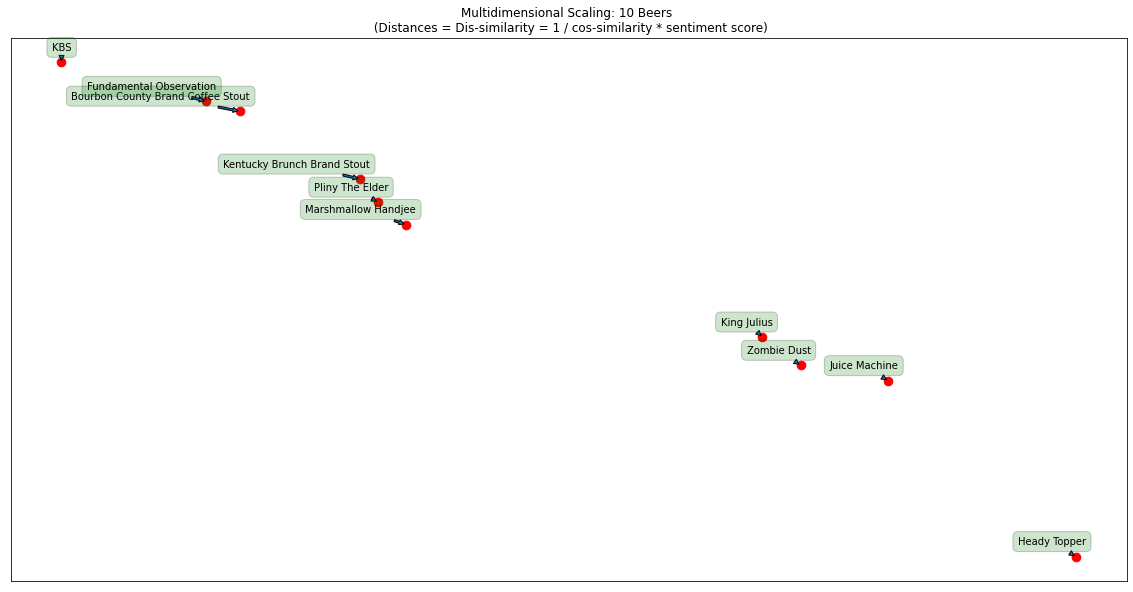

In [ ]:
mds=manifold.MDS(n_components=2, dissimilarity ='euclidean', random_state=10)

df = beer_score[['Beer','total score']]
df = df[df['Beer'].map(lambda x: x in beer_list)].set_index('Beer')
df = df['total score'].map(lambda x: 1/x if x != 0 else 0).to_frame()

results=mds.fit(df)
coordinates=results.embedding_

x = coordinates[:,0]
y = coordinates[:,1]

plt.figure(figsize=(20,10))
plt.scatter(x,y, marker='o', color='red', s=75)

for brand, x_coord, y_coord in zip(beer_list, x, y):
  plt.annotate(s=brand, 
               xy=(x_coord,y_coord),
               xytext = (10, 10),
               textcoords = 'offset points', 
               ha = 'right', 
               va = 'bottom',
               bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.2),
               arrowprops = dict(arrowstyle = 'simple', connectionstyle = 'arc3,rad=0'))

plt.xticks([])
plt.yticks([])
plt.title('Multidimensional Scaling: 10 Beers \n (Distances = Dis-similarity = 1 / cos-similarity * sentiment score)')
plt.show()

### Cosine-smilarity on lift values of each beer

In [ ]:
from scipy import spatial
from scipy.spatial import distance

similarity_list = []
beer1 = feature_matrix.iloc[0]

for i in range(1,10):
  beer2 = feature_matrix.iloc[i]
  similarity = 1- distance.cosine(beer1, beer2)
  similarity_list.append(similarity)
  print('Similarity between {} and {} is {}'.format(beer1.name, beer2.name, similarity))


Similarity between Heady Topper and Bourbon County Brand Coffee Stout is 0.8045194279610138
Similarity between Heady Topper and Pliny The Elder is 0.9457220321216633
Similarity between Heady Topper and KBS is 0.7375359901780318
Similarity between Heady Topper and Zombie Dust is 0.8123113257432126
Similarity between Heady Topper and Kentucky Brunch Brand Stout is 0.662868041719544
Similarity between Heady Topper and Marshmallow Handjee is 0.8700047607027743
Similarity between Heady Topper and King Julius is 0.9266343054838585
Similarity between Heady Topper and Fundamental Observation is 0.7372488614205841
Similarity between Heady Topper and Juice Machine is 0.8386891488014182


In [ ]:
most_smilar_beer = feature_matrix.index.values[similarity_list.index(max(similarity_list))+1]
print('The most similar beer to {} is {}'.format(beer1.name,most_smilar_beer))

The most similar beer to Heady Topper is Pliny The Elder


##Task H Insights:

While making choices of 10 different beers, we picked 5 beers with relatively higher amounts of reviews, and the other 5 beers with relatively lower amounts of reviews on purpose. The reason we did this is because we are tring to see if we can generate a less-popular but similar beer to the popular one we are currently looking. 

We used three different ways to solve this problem:
- Generate 4 MDS maps, with each map showing the dis-similarity (1/lift) among all 10 beers regrding 1 single feature
- Generate 1 MDS map by using the cosine-similarity values between each beer and the 4 features. Hence, there are total 11 points in the MDS map, including 10 points represent 10 different beers, and 1 point representing the 4 features.
- Using vectors (containing lift values between each beer and 4 features) to represent each beer, and calculate the cosine-similarity between each two vectors.

If we choose the beer Heady Topper, the most similar beer to the chosen would be Pliny The Elder as it had a similarity value of 0.9457.

In the cosine similarity MDS map, we can see no other beer is around Heady Topper, but according to the other 4 MDS maps by using lift values, we can see Pliny The Elder is somewhere around Heady Topper in 3 of the features. 
